<a href="https://colab.research.google.com/github/ewattudo/datamanagement/blob/main/ps4_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PS4 - Emperical Ananlysis of Hunter and Robinsons' (2018) C*hocolate Cities* Map

# Setup, Import, Manipulation and Merge

## Setup Code

In [286]:
#Using code from previous projects and Dr. Adam
import time, os, sys, re #basics
import zipfile, json, datetime, string
import numpy as np #basic math
from statistics import * #stats
from scipy.stats import f_oneway
from scipy.stats import skew
from scipy.stats import kruskal

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cm

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
import requests

import missingno as msno

from google.colab import files

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter()
data_table.max_columns = 50

import pandas as pd
import urllib.request
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

!pip install geopandas==1.0.1
!pip install mapclassify
import geopandas as gpd

import time, webbrowser, zipfile

from google.colab import data_table
data_table.enable_dataframe_formatter()

import plotly.express as px
import plotly.graph_objects as go

!pip install ydata-profiling
from ydata_profiling import ProfileReport

from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer

!pip install adjustText
from adjustText import adjust_text

!pip install tabula-py
import tabula

## US Map (SHP) Import and Manipulation

### US Map (SHP) Import

**Source: US Census:**
https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip

**Project for the future:** I really want a US map with Hawaii and Alaska inset. I tried to find one quite unsuccessfully.

In [131]:
! wget -q -O US.zip https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip

zip_ref = zipfile.ZipFile('US.zip', 'r'); zip_ref.extractall(); zip_ref.close()

In [132]:
US=gpd.read_file('/content/cb_2018_us_state_500k.shp')

### US Map (SHP) Manipulation

Having used this data before, I know that I am goning to have to rename some fields for merging and get rid of some of the states.

In [133]:
#I am going to have to rename NAME
US.dtypes

,0
STATEFP,object
STATENS,object
AFFGEOID,object
GEOID,object
STUSPS,object
NAME,object
LSAD,object
ALAND,int64
AWATER,int64
geometry,geometry


In [134]:
#I want to rename NAME colume to State
US.rename(columns={'NAME':'State'}, inplace=True)

In [135]:
#I only want to look at states, not territories.
#I removed HI and AK, but if I do this for further study. I can't remove them, but the map looks off when I include them.
US = US[~US['State'].isin(['Alaska','District of Columbia','Hawaii','Puerto Rico','American Samoa','United States Virgin Islands','Guam','Commonwealth of the Northern Mariana Islands'])]

## State Political Party Composition (PDF) Import and Manipulation

### State Political Party Composition (PDF) Import

In [136]:
#I was able to get this PDF extraction code from https://colab.research.google.com/github/Jonchyk/Datamgmt/blob/main/PS2Complex.ipynb#scrollTo=qOV77LSLJCkM.
#This is going to need some manipulating. I might want to dig down in this in my dissertation, but for this project. I think I am going to focus on using this as categorical data.
!wget --no-check-certificate "https://documents.ncsl.org/wwwncsl/Elections/LegisControl_2010.pdf" -O leg2010.pdf
leg = tabula.read_pdf('leg2010.pdf', multiple_tables=False, stream=True)
leg[0].head()

--2025-03-22 21:56:38--  https://documents.ncsl.org/wwwncsl/Elections/LegisControl_2010.pdf
Resolving documents.ncsl.org (documents.ncsl.org)... 13.107.246.70, 2620:1ec:bdf::70
Connecting to documents.ncsl.org (documents.ncsl.org)|13.107.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117163 (114K) [application/pdf]
Saving to: ‘leg2010.pdf’

leg2010.pdf         100%[===================>] 114.42K  --.-KB/s    in 0.01s   

2025-03-22 21:56:38 (8.27 MB/s) - ‘leg2010.pdf’ saved [117163/117163]



Mar 22, 2025 9:56:40 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 22, 2025 9:56:47 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 22, 2025 9:56:47 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



,Unnamed: 0,Total,Total.1,Senate Senate,Senate,Unnamed: 5,Total.2,House House,House,Unnamed: 9,Legis.,Gov.,State
0,STATE,Seats,Senate,Dem. Rep.,NaN,other,House,Dem. Rep.,NaN,other,Control,Party,Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem


### State Political Party Composition (PDF) Manipulation

In [137]:
#This doesn't look right. The first row is nonsense.
leg[0].columns = leg[0].columns.astype(str) + '_' + leg[0].iloc[0].astype(str)
leg[0].head()

,Unnamed: 0_STATE,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,State_Control
0,STATE,Seats,Senate,Dem. Rep.,NaN,other,House,Dem. Rep.,NaN,other,Control,Party,Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem


In [138]:
#I want to remove the row 0 it is not data, it's merge error.
leg[0] = leg[0].drop(0)

In [139]:
#This is not quite there, but it's usable. I am not going to edit all these columns.
leg[0].head()

,Unnamed: 0_STATE,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,State_Control
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem
5,California,120,40,25 14,NaN,1v,80,49 29,NaN,"1, 1v",Dem,Rep,Divided


In [140]:
#I want the numbers here for future study, largely because of Furrer, et al (2023), referred to previously. The categorization here is a gross simplification done for parsimony.
#I want to make the leg dataset, Unnamed: 0_State and State_Control
leg[0] = leg[0].rename(columns={'Unnamed: 0_STATE': 'State', 'State_Control': 'Party'})
leg[0].head()

,State,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Legis._Control,Gov._Party,Party
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem
5,California,120,40,25 14,NaN,1v,80,49 29,NaN,"1, 1v",Dem,Rep,Divided


In [141]:
#I want to create a leg df from leg[0]
leg = leg[0]

In [142]:
#I want to rename Leg._Control to Leg and Gov._Party to Gov
#I decided I want to disaggregate Party for the analysis. Party should be names something else, but I'll leave it.
leg = leg.rename(columns={'Legis._Control': 'Leg', 'Gov._Party': 'Gov'})
leg.head()

,State,Total_Seats,Total.1_Senate,Senate Senate_Dem. Rep.,Senate_nan,Unnamed: 5_other,Total.2_House,House House_Dem. Rep.,House_nan,Unnamed: 9_other,Leg,Gov,Party
1,Alabama,140,35,21 14,NaN,0,105,60 45,NaN,0,Dem,Rep,Divided
2,Alaska,60,20,10 10,NaN,0,40,18 22,NaN,0,Split,Rep,Divided
3,Arizona,90,30,12 18,NaN,0,60,25 35,NaN,0,Rep,Rep,Rep
4,Arkansas,135,35,27 8,NaN,0,100,71 28,NaN,1,Dem,Dem,Dem
5,California,120,40,25 14,NaN,1v,80,49 29,NaN,"1, 1v",Dem,Rep,Divided


In [143]:
#In Leg and Gov, I want to replace and occurence of Split with Divided
leg['Leg'] = leg['Leg'].str.replace('Split', 'Divided')
leg['Gov'] = leg['Gov'].str.replace('Split', 'Divided')

In [144]:
#I want to create the leg2020 df that includes State, Leg, Gov and Party
leg2010 = leg[['State', 'Leg','Gov','Party']]
leg2010.head()

,State,Leg,Gov,Party
1,Alabama,Dem,Rep,Divided
2,Alaska,Divided,Rep,Divided
3,Arizona,Rep,Rep,Rep
4,Arkansas,Dem,Dem,Dem
5,California,Dem,Rep,Divided


## African-American Population by State and Over Time (HTML)

Source: Wikipedia https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_African-American_population

### African-American Population by State and Over Time (HTML) Import

In [163]:
aapop = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_African-American_population',match="State/Territory")[0].head(65)
aapop.head(5)

,State/Territory,1790,1800,1810,1820,1830,1840,1850,1860,1870,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
0,United States of America,19.3%,18.9%,19.0%,18.4%,18.1%,16.8%,15.7%,14.1%,12.7%,...,9.7%,9.8%,10.0%,10.5%,11.1%,11.7%,12.1%,12.9%,13.6%,14.2%
1,Alabama,NaN,41.4%,29.0%,33.2%,38.5%,43.3%,44.7%,45.4%,47.7%,...,35.7%,34.7%,32.0%,30.0%,26.2%,25.6%,25.3%,26.0%,26.3%,26.8%
2,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2%,0.2%,NaN,3.0%,3.0%,3.4%,4.1%,4.3%,4.7%,4.8%
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02%,0.04%,0.02%,NaN
4,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3%,0.3%,...,2.5%,3.0%,3.5%,3.3%,3.0%,2.8%,3.0%,3.6%,5.0%,6.2%


### African-American Population by State and Over Time (HTML) Manipulating

In [164]:
#All objects. I am going to have to turn all these into numbers.
aapop.dtypes

,0
State/Territory,object
1790,object
1800,object
1810,object
1820,object
1830,object
1840,object
1850,object
1860,object
1870,object


In [165]:
#AI made it easy. It seems to anticipate that I wanted to change it.
aapop['1790'] = aapop['1790'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1800'] = aapop['1800'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1810'] = aapop['1810'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1820'] = aapop['1820'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1830'] = aapop['1830'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1840'] = aapop['1840'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1850'] = aapop['1850'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1860'] = aapop['1860'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1870'] = aapop['1870'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1880'] = aapop['1880'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1890'] = aapop['1890'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1900'] = aapop['1900'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1910'] = aapop['1910'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1920'] = aapop['1920'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1930'] = aapop['1930'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1940'] = aapop['1940'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1950'] = aapop['1950'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1960'] = aapop['1960'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1970'] = aapop['1970'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1980'] = aapop['1980'].str.replace('[\%]', '', regex=True).astype(float)
aapop['1990'] = aapop['1990'].str.replace('[\%]', '', regex=True).astype(float)
aapop['2000'] = aapop['2000'].str.replace('[\%]', '', regex=True).astype(float)
aapop['2010'] = aapop['2010'].str.replace('[\%]', '', regex=True).astype(float)
aapop['2020'] = aapop['2020'].str.replace('[\%]', '', regex=True).astype(float)

In [167]:
aapop.describe()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
count,19.000000,26.000000,29.000000,30.000000,31.000000,32.000000,38.000000,45.000000,49.000000,49.000000,...,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,56.000000,57.000000,57.000000,53.000000
mean,15.352632,16.534615,18.372414,17.683333,19.345161,18.687500,15.992105,13.171111,12.526531,12.571429,...,9.496154,9.253846,9.374510,9.728846,10.021154,10.365385,11.315536,12.007193,12.637018,12.771698
std,14.957806,15.993872,17.620299,17.930807,19.389737,19.595008,18.826640,18.269306,18.141318,18.416354,...,13.434999,12.874621,11.839068,11.991375,12.524444,12.395586,14.720913,14.392811,13.805798,10.193218
min,0.300000,0.400000,0.300000,0.300000,0.200000,0.200000,0.000000,0.000000,0.100000,0.200000,...,0.100000,0.000000,0.000000,0.100000,0.200000,0.200000,0.020000,0.040000,0.020000,1.200000
25%,2.350000,2.950000,2.900000,2.200000,1.650000,1.075000,0.600000,0.300000,0.600000,0.500000,...,0.400000,0.400000,0.850000,1.525000,1.750000,1.800000,2.150000,2.500000,2.900000,5.000000
50%,9.500000,8.900000,13.000000,11.900000,15.500000,12.600000,3.700000,1.600000,1.800000,1.900000,...,3.400000,3.600000,4.400000,5.200000,6.350000,6.900000,6.850000,7.500000,8.700000,9.700000
75%,24.200000,30.150000,32.200000,32.700000,35.400000,33.125000,27.275000,24.900000,22.500000,22.500000,...,13.950000,13.725000,13.200000,12.700000,13.175000,14.025000,15.075000,15.600000,16.100000,17.200000
max,43.700000,44.600000,55.200000,52.800000,58.500000,56.400000,58.900000,58.600000,58.900000,60.700000,...,50.200000,49.200000,45.300000,53.900000,71.100000,70.300000,76.620000,76.190000,76.030000,44.200000


In [168]:
#I need to rename State/Territory to State
aapop = aapop.rename(columns={'State/Territory': 'State'})
aapop.head()

,State,1790,1800,1810,1820,1830,1840,1850,1860,1870,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
0,United States of America,19.3,18.9,19.0,18.4,18.1,16.8,15.7,14.1,12.7,...,9.7,9.8,10.0,10.5,11.1,11.7,12.10,12.90,13.60,14.2
1,Alabama,NaN,41.4,29.0,33.2,38.5,43.3,44.7,45.4,47.7,...,35.7,34.7,32.0,30.0,26.2,25.6,25.30,26.00,26.30,26.8
2,Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,0.2,NaN,3.0,3.0,3.4,4.10,4.30,4.70,4.8
3,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.04,0.02,NaN
4,Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.3,...,2.5,3.0,3.5,3.3,3.0,2.8,3.00,3.60,5.00,6.2


## African-American Census Data (API) Importing and Manipulating

### Importing Census Data

In [250]:
url = "https://api.census.gov/data/2010/acs/acs5"
params = {
    "get": "B19013B_001E,B17001B_002E,C15002B_009E,C15002B_010E,B02001_002E",
    "for": "state:*"
}
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    census = pd.DataFrame(data[1:], columns=data[0])
    census = census.rename(columns={
        "B19013B_001E": "HHInc",
        "B17001B_002E": "Pov",
        "C15002B_009E": "Bach",
        "C15002B_010E": "Grad",
        "B02001_002E": "Pop",
        "state": "State"
        })
census.head()

,HHInc,Pov,Bach,Grad,Pop,State
0,27621,356477,125451,125873,3293917,01
1,55063,2316,1294,2688,464150,02
2,40945,50515,14781,28090,4883606,04
3,25509,144339,47152,42814,2253875,05
4,44127,437531,168768,309283,22392713,06


### Manipulating Census Data

In [253]:
#The State field is FIPS, I want to change it to State names
#The internal AI made this easy
state_mapping = {
    "01": "Alabama", "02": "Alaska", "04": "Arizona", "05": "Arkansas", "06": "California",
    "08": "Colorado", "09": "Connecticut", "10": "Delaware", "11": "District of Columbia", "12": "Florida",
    "13": "Georgia", "15": "Hawaii", "16": "Idaho", "17": "Illinois", "18": "Indiana",
    "19": "Iowa", "20": "Kansas", "21": "Kentucky", "22": "Louisiana", "23": "Maine",
    "24": "Maryland", "25": "Massachusetts", "26": "Michigan", "27": "Minnesota", "28": "Mississippi",
    "29": "Missouri", "30": "Montana", "31": "Nebraska", "32": "Nevada", "33": "New Hampshire",
    "34": "New Jersey", "35": "New Mexico", "36": "New York", "37": "North Carolina", "38": "North Dakota",
    "39": "Ohio", "40": "Oklahoma", "41": "Oregon", "42": "Pennsylvania", "44": "Rhode Island",
    "45": "South Carolina", "46": "South Dakota", "47": "Tennessee", "48": "Texas", "49": "Utah",
    "50": "Vermont", "51": "Virginia", "53": "Washington", "54": "West Virginia", "55": "Wisconsin",
    "56": "Wyoming"
}
census['State'] = census['State'].map(state_mapping)
census.head()

,HHInc,Pov,Bach,Grad,Pop,State
0,27621,356477,125451,125873,3293917,Alabama
1,55063,2316,1294,2688,464150,Alaska
2,40945,50515,14781,28090,4883606,Arizona
3,25509,144339,47152,42814,2253875,Arkansas
4,44127,437531,168768,309283,22392713,California


In [257]:
#I need to change HHInc, Pov, Bach,Grad, Pop into numbers
census['HHInc'] = census['HHInc'].astype(int)
census['Pov'] = census['Pov'].astype(int)
census['Bach'] = census['Bach'].astype(int)
census['Grad'] = census['Grad'].astype(int)
census['Pop'] = census['Pop'].astype(int)
census.dtypes

,0
HHInc,int64
Pov,int64
Bach,int64
Grad,int64
Pop,int64
State,object


In [333]:
#I want to add Bach to Grad to create a field called HED
census['HED'] = census['Bach'] + census['Grad']
census.head()

,HHInc,Pov,Bach,Grad,Pop,State,HED,PovPop,BachPop,GradPop,HEDPop
0,27621,356477,125451,125873,3293917,Alabama,251324,0.108,0.038,0.038,0.076
1,55063,2316,1294,2688,464150,Alaska,3982,0.005,0.003,0.006,0.009
2,40945,50515,14781,28090,4883606,Arizona,42871,0.010,0.003,0.006,0.009
3,25509,144339,47152,42814,2253875,Arkansas,89966,0.064,0.021,0.019,0.040
4,44127,437531,168768,309283,22392713,California,478051,0.020,0.008,0.014,0.021


In [334]:
#I want to create fields Pov/Pop, Bach/Pop, Grad/Pop and HED/Pop
census['PovPop'] = (census['Pov'] / census['Pop']).round(3)
census['BachPop'] = (census['Bach'] / census['Pop']).round(3)
census['GradPop'] = (census['Grad'] / census['Pop']).round(3)
census['HEDPop'] = (census['HED'] / census['Pop']).round(3)
census.head()

,HHInc,Pov,Bach,Grad,Pop,State,HED,PovPop,BachPop,GradPop,HEDPop
0,27621,356477,125451,125873,3293917,Alabama,251324,0.108,0.038,0.038,0.076
1,55063,2316,1294,2688,464150,Alaska,3982,0.005,0.003,0.006,0.009
2,40945,50515,14781,28090,4883606,Arizona,42871,0.010,0.003,0.006,0.009
3,25509,144339,47152,42814,2253875,Arkansas,89966,0.064,0.021,0.019,0.040
4,44127,437531,168768,309283,22392713,California,478051,0.020,0.008,0.014,0.021


In [255]:
census.dtypes

,0
HHInc,object
Pov,object
Bach,object
Grad,object
Pop,object
State,object


## Creating the Chocolate Cities Base Map

### Using Mapping to Create the AllSouth FIeld

In [145]:
#Revised Chocolate Cities-style region mapping
chocolate_cities_mapping = {
    # OUT SOUTH
    "Montana": "OUT SOUTH", "Wyoming": "OUT SOUTH", "Idaho": "OUT SOUTH",
    "Washington": "OUT SOUTH", "Oregon": "OUT SOUTH",

    # WEST SOUTH
    "Colorado": "WEST SOUTH", "New Mexico": "WEST SOUTH", "Arizona": "WEST SOUTH", "Utah": "WEST SOUTH",
    "California": "WEST SOUTH", "Nevada": "WEST SOUTH", "Texas": "WEST SOUTH",

    # MID SOUTH
    "Missouri": "MID SOUTH", "Kansas": "MID SOUTH", "Illinois": "MID SOUTH",
    "Indiana": "MID SOUTH", "Iowa": "MID SOUTH", "Nebraska": "MID SOUTH",
    "Michigan": "MID SOUTH", "Oklahoma": "MID SOUTH", "South Dakota": "MID SOUTH",
    "Ohio": "MID SOUTH", "Wisconsin": "MID SOUTH", "Minnesota": "MID SOUTH",
    "North Dakota": "MID SOUTH", "Kentucky": "MID SOUTH", "West Virginia": "MID SOUTH",

    # UP SOUTH
    "New York": "UP SOUTH", "Massachusetts": "UP SOUTH", "Connecticut": "UP SOUTH",
    "Rhode Island": "UP SOUTH", "New Jersey": "UP SOUTH", "Vermont": "UP SOUTH",
    "New Hampshire": "UP SOUTH", "Maine": "UP SOUTH", "Pennsylvania": "UP SOUTH",
    "Maryland": "UP SOUTH", "Delaware": "UP SOUTH",

    # DOWN SOUTH
    "Virginia": "DOWN SOUTH", "North Carolina": "DOWN SOUTH", "South Carolina": "DOWN SOUTH",
    "Florida": "DOWN SOUTH", "Georgia": "DOWN SOUTH",

    # DEEP SOUTH
    "Alabama": "DEEP SOUTH", "Mississippi": "DEEP SOUTH",
    "Louisiana": "DEEP SOUTH", "Tennessee": "DEEP SOUTH", "Arkansas": "DEEP SOUTH"
}

# Apply the updated mapping to your GeoDataFrame
US["AllSouth"] = US["State"].map(chocolate_cities_mapping)

In [146]:
#Checking to see if I missed any states
US[US["AllSouth"].isnull()]["State"]

,State


## Merging

### Merging Census

In [263]:
#I want to mege census with US outer and include indicators
US = pd.merge(US, census, on='State', how='outer',indicator=True)
US['_merge'].value_counts()

,count
_merge,
both,48
right_only,4
left_only,0


In [265]:
#I want to see the _merge values for right_only
#All of it makes sense other than 51. I am not sure how to find out what that is. It's OK because I have my lower 48.
US[US['_merge'] == 'right_only']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry,...,Pov,Bach,Grad,Pop,HED,PovPop,BachPop,GradPop,HEDPop,_merge
1,NaN,NaN,NaN,NaN,NaN,Alaska,NaN,NaN,NaN,None,...,2316,1294,2688,464150,3982,0.005,0.003,0.006,0.009,right_only
8,NaN,NaN,NaN,NaN,NaN,District of Columbia,NaN,NaN,NaN,None,...,77167,37655,29932,222375,67587,0.347,0.169,0.135,0.304,right_only
11,NaN,NaN,NaN,NaN,NaN,Hawaii,NaN,NaN,NaN,None,...,1859,775,2410,333842,3185,0.006,0.002,0.007,0.010,right_only
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,...,127126,23708,20491,2761508,44199,0.046,0.009,0.007,0.016,right_only


In [266]:
#I want to get rid of the right_only in _merge
US = US[US['_merge'] != 'right_only']
US = US.drop(columns=['_merge'])

### Merging Leg

In [147]:
#I want to merge US and leg2010 outer on State
US = pd.merge(US, leg2010, on='State', how='outer',indicator=True)

In [148]:
#I want to see the results of the _merge field
US['_merge'].value_counts()

,count
_merge,
both,48
right_only,12
left_only,0


In [149]:
#I want to see the values in the right_only in _merge
#This looks right, it's all terrirtories, and non states. I always lament not being able to include Alaska and Hawaii. But Hunter and Robinson (2018) don't either.
US[US['_merge'] == 'right_only']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry,AllSouth,Leg,Gov,Party,_merge
1,NaN,NaN,NaN,NaN,NaN,Alaska,NaN,NaN,NaN,None,NaN,Divided,Rep,Divided,right_only
2,NaN,NaN,NaN,NaN,NaN,American Samoa,NaN,NaN,NaN,None,NaN,NaN,Ind,NaN,right_only
9,NaN,NaN,NaN,NaN,NaN,District of Columbia,NaN,NaN,NaN,None,NaN,Dem,NaN,NaN,right_only
12,NaN,NaN,NaN,NaN,NaN,Guam,NaN,NaN,NaN,None,NaN,Dem,Rep,Divided,right_only
13,NaN,NaN,NaN,NaN,NaN,Hawaii,NaN,NaN,NaN,None,NaN,Dem,Rep,Divided,right_only
22,NaN,NaN,NaN,NaN,NaN,Mariana Islands,NaN,NaN,NaN,None,NaN,Divided,Cov,Divided,right_only
42,NaN,NaN,NaN,NaN,NaN,Puerto Rico,NaN,NaN,NaN,None,NaN,NPP,NPP,NPP,right_only
48,NaN,NaN,NaN,NaN,NaN,Total,NaN,NaN,NaN,None,NaN,8 Divided,24R,24 Div,right_only
49,NaN,NaN,NaN,NaN,NaN,U.S. Territories,NaN,NaN,NaN,None,NaN,Control,Party,Control,right_only
52,NaN,NaN,NaN,NaN,NaN,Virgin Islands,NaN,NaN,NaN,None,NaN,NaN,Dem,NaN,right_only


In [150]:
#In US I want to delete all the values where _merge is right_only and then I wantto delete the _merge field
US = US[US['_merge'] != 'right_only']
US = US.drop(columns=['_merge'])

In [151]:
#I want to count in US of States by Party
#Interesting, I didn't anticipate that it would be so divided. I thought it would be overwelmingly Rep.
US['Party'].value_counts()

,count
Party,
Divided,22
Dem,16
Rep,9


### Merging AAPOP

In [169]:
#I want to merge aapop with US on State outer with indicator
US = pd.merge(US, aapop, on='State', how='outer',indicator=True)
US['_merge'].value_counts()

,count
_merge,
both,48
right_only,9
left_only,0


In [170]:
#I need to see the values of right_only in _merge
#These make sense.
US[US['_merge'] == 'right_only']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry,...,1940,1950,1960,1970,1980,1990,2000,2010,2020,_merge
1,NaN,NaN,NaN,NaN,NaN,Alaska,NaN,NaN,NaN,None,...,0.2,NaN,3.0,3.0,3.4,4.10,4.30,4.70,4.8,right_only
2,NaN,NaN,NaN,NaN,NaN,American Samoa,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,0.02,0.04,0.02,NaN,right_only
9,NaN,NaN,NaN,NaN,NaN,District of Columbia,NaN,NaN,NaN,None,...,28.2,35.0,53.9,71.1,70.3,65.80,61.30,52.20,44.2,right_only
12,NaN,NaN,NaN,NaN,NaN,Guam,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,2.37,1.02,0.96,NaN,right_only
13,NaN,NaN,NaN,NaN,NaN,Hawaii,NaN,NaN,NaN,None,...,0.1,0.5,0.8,1.0,1.8,2.50,2.80,2.90,3.2,right_only
37,NaN,NaN,NaN,NaN,NaN,Northern Mariana Islands,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,0.06,0.06,0.10,NaN,right_only
42,NaN,NaN,NaN,NaN,NaN,Puerto Rico,NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,10.90,14.80,17.5,right_only
48,NaN,NaN,NaN,NaN,NaN,United States of America,NaN,NaN,NaN,None,...,9.8,10.0,10.5,11.1,11.7,12.10,12.90,13.60,14.2,right_only
51,NaN,NaN,NaN,NaN,NaN,Virgin Islands (U.S.),NaN,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,76.62,76.19,76.03,NaN,right_only


In [171]:
#I want to delete all the records where _merge is _right only and delete _merge
US = US[US['_merge'] != 'right_only']
US = US.drop(columns=['_merge'])

### Merged File Manipulation: Reshaping Party Data

In [152]:
#I want to create a down_party df that includes Party, AllSouth and create a new field called Total so I can create sunbursts
down_party = (
    US.groupby(['Party', 'AllSouth'])
      .size()
      .reset_index(name='Total')
)
down_party.head(10)

,Party,AllSouth,Total
0,Dem,DEEP SOUTH,1
1,Dem,DOWN SOUTH,1
2,Dem,MID SOUTH,4
3,Dem,OUT SOUTH,2
4,Dem,UP SOUTH,6
5,Dem,WEST SOUTH,2
6,Divided,DEEP SOUTH,4
7,Divided,DOWN SOUTH,1
8,Divided,MID SOUTH,8
9,Divided,OUT SOUTH,2


### Merged File Manipulation: Reshaping Population Data

In [176]:
#I want to make a dataframe from a pivot of AllSouth that creates the mean of the values 1790 through 2010
US_pop = US.pivot_table(index='AllSouth', values=['1790', '1800', '1810', '1820', '1830', '1840', '1850', '1860', '1870', '1880',
                                                 '1890', '1900', '1910', '1920', '1930', '1940', '1950', '1960', '1970', '1980',
                                                 '1990', '2000', '2010', '2020'], aggfunc='mean')
US_pop.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
AllSouth,,,,,,,,,,,,,,,,,,,,,
DEEP SOUTH,10.600000,32.033333,32.340000,32.080000,36.460000,38.840000,38.760000,40.260000,40.460000,41.780000,...,33.380000,32.400000,29.720000,28.440000,25.380000,24.460000,24.720000,25.660000,26.040000,26.320000
DOWN SOUTH,37.450000,38.575000,42.550000,44.850000,45.820000,45.720000,45.740000,45.380000,46.440000,46.900000,...,33.520000,31.380000,27.880000,25.240000,22.480000,22.460000,22.240000,23.420000,24.120000,24.080000
MID SOUTH,13.250000,7.400000,8.871429,7.312500,7.550000,5.966667,4.810000,3.169231,2.971429,2.907143,...,3.386667,3.406667,3.953333,4.733333,5.413333,5.906667,6.320000,7.173333,8.073333,9.120000
OUT SOUTH,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.250000,0.920000,0.640000,...,0.320000,0.260000,0.680000,0.760000,0.960000,1.040000,1.220000,1.720000,2.100000,2.680000
UP SOUTH,7.772727,7.800000,7.881818,7.509091,7.245455,6.872727,5.945455,5.172727,4.827273,4.827273,...,4.409091,4.509091,5.045455,5.809091,6.900000,8.054545,8.981818,10.454545,11.727273,12.818182


In [184]:
#I want to create a line graph so of US_Pop so I need to stack it
US_pop = US_pop.fillna(0)
US_pop_down = US_pop.stack().reset_index()
US_pop_down.columns = ['Region', 'Year', 'Mean Pop Prop']
US_pop_down.head()

,Region,Year,Mean Pop Prop
0,DEEP SOUTH,1790,10.600000
1,DEEP SOUTH,1800,32.033333
2,DEEP SOUTH,1810,32.340000
3,DEEP SOUTH,1820,32.080000
4,DEEP SOUTH,1830,36.460000


#*Chocolate Cities* Analysis

## Chocolate Cities Base Map

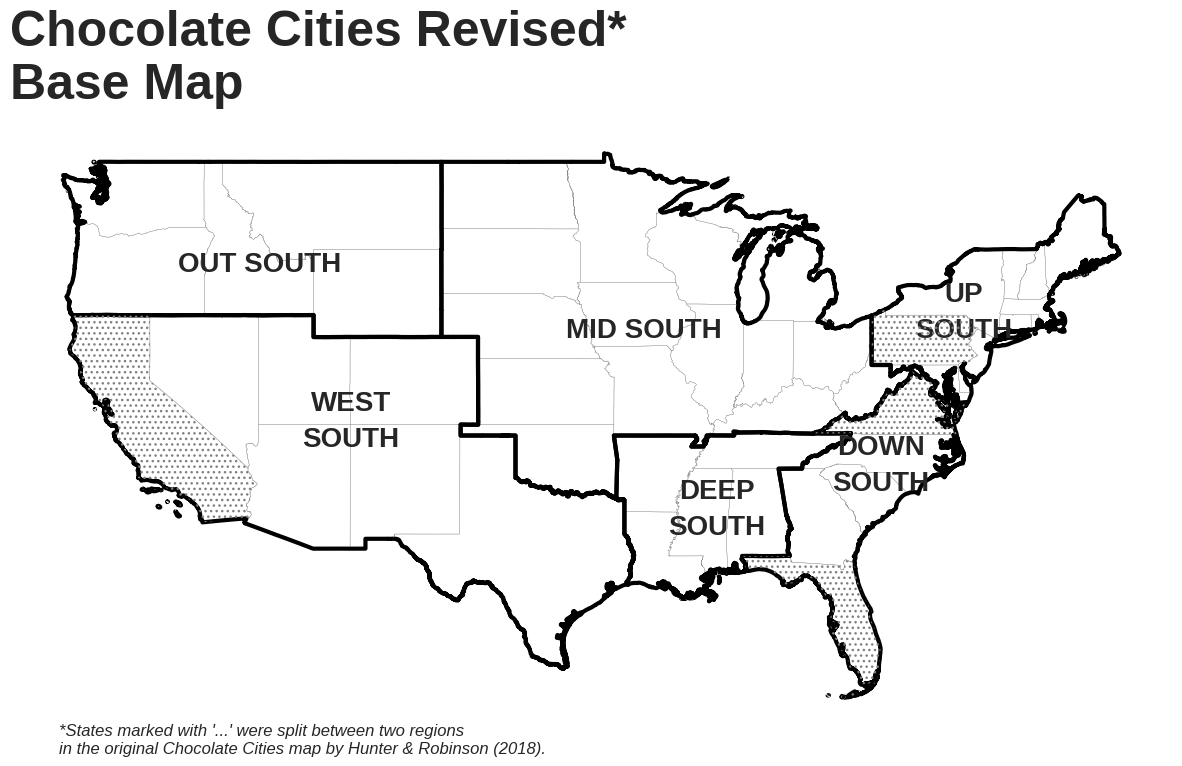

In [153]:
regions = US.dissolve(by='AllSouth')

fig, ax = plt.subplots(1, figsize=(15, 50))

US.boundary.plot(ax=ax, edgecolor='grey', linewidth=0.20)

regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Clean up axes
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Large, two-line title using ax.set_title with increased padding
ax.set_title("Chocolate Cities Revised*\nBase Map",
             loc='left', fontsize=36, fontweight='bold', pad=20)

ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).",
        fontsize=12, ha='left', fontstyle='italic')

# Final label positions and text
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),   # moved slightly right
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}

label_text = {
    "OUT SOUTH": "OUT SOUTH",           # one line
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",           # one line
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}

# Add labels
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Overlay hatch on split states (California, Virginia, Florida, Pennsylvania)
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]

split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5  # Keep it above other layers
)

plt.show()

In [193]:
US_pop_down['Year'] = US_pop_down['Year'].astype(int)

# Get y-axis range
y_min = US_pop_down['Mean Pop Prop'].min()
y_max = US_pop_down['Mean Pop Prop'].max()

# Create base figure
fig = px.line(
    US_pop_down,
    x="Year",
    y="Mean Pop Prop",
    color="Region",
    title="Mean Population Proportion by Chocolate Cities Region Over Time\n(The shaded area represents the Great Migration, 1910–1970)"
)

# Convert to graph object
fig = go.Figure(fig)

# Add shaded rectangle for Great Migration
fig.add_shape(
    type="rect",
    x0=1910, x1=1970,
    y0=y_min, y1=y_max,
    fillcolor="gray",
    opacity=0.3,
    layer="below",
    line_width=0
)

# Final layout tweaks
fig.update_layout(
    yaxis_range=[y_min, y_max],
    xaxis_title="Year",
    yaxis_title="Mean Population Proportion",
    title_x=0.0,
    plot_bgcolor="white",
    margin=dict(t=100)
)

fig.show()

In [215]:
# Check skewness for each region
skew_by_region = US_pop_down.groupby('Region')['Mean Pop Prop'].apply(lambda x: skew(x.dropna()))
print(skew_by_region)

Region
DEEP SOUTH   -0.883185
DOWN SOUTH   -0.320330
MID SOUTH     1.000121
OUT SOUTH     1.364392
UP SOUTH      0.966424
WEST SOUTH   -0.358219
Name: Mean Pop Prop, dtype: float64


In [217]:
#I wanted to use ANOVA but the data is too skewed for Mid South and really close for Out South so I found the Krushkall-Wallis test
groups = US_pop_down.groupby('Region')['Mean Pop Prop']
samples = [group for name, group in groups if group.nunique() > 1]
stat, p = kruskal(*samples)

print("Kruskal-Wallis H-statistic:", stat)
print("p-value:", p)

Kruskal-Wallis H-statistic: 118.8270071759896
p-value: 5.5609943712860554e-24


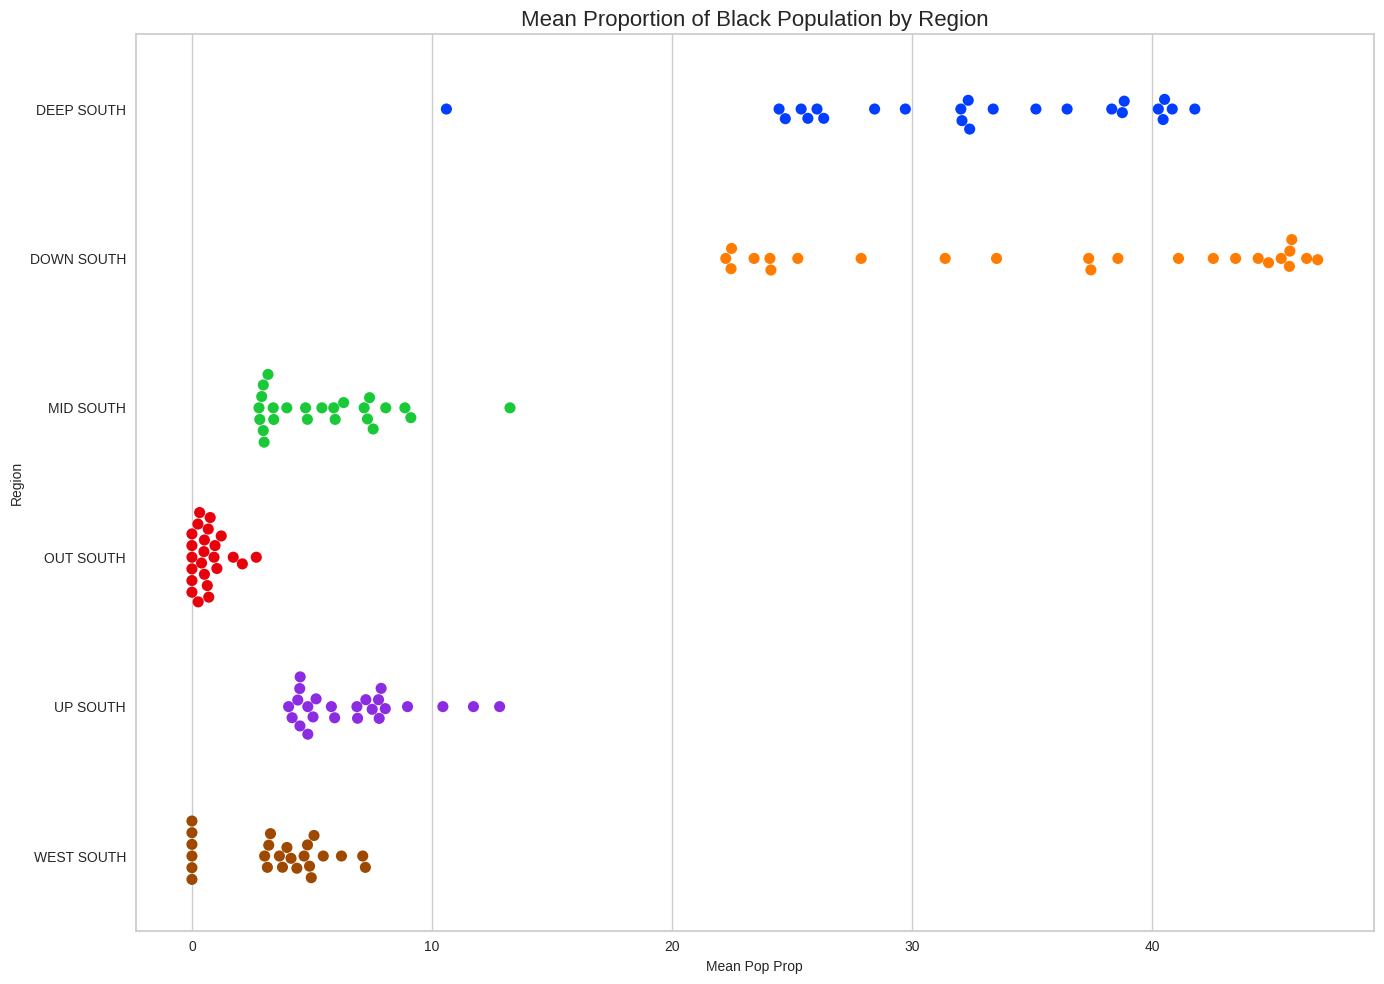

In [330]:
plt.figure(figsize=(14, 10))  # Bigger plot for more points

sns.swarmplot(
    data=US_pop_down,
    x="Mean Pop Prop",
    y="Region",
    hue="Region",
    palette="bright",
    size=8
)

plt.title("Mean Proportion of Black Population by Region", fontsize=16)
plt.xlabel("Mean Pop Prop", fontsize=10)
plt.ylabel("Region", fontsize=10)
plt.tight_layout()
plt.show()

In [194]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ensure your data is clean and column names have no spaces
model = ols('Q("Mean Pop Prop") ~ C(Region)', data=US_pop_down).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                 sum_sq     df         F        PR(>F)
C(Region)  29487.864322    5.0  213.4874  4.178408e-63
Residual    3812.239291  138.0       NaN           NaN


## Chocolate Cities Map Evaluating Political Party Control

In [154]:
#I want a pivot that groups by AllSOuth and Counts values in Party
US.pivot_table(index='Party', columns='AllSouth', values='State', aggfunc='count')

AllSouth,DEEP SOUTH,DOWN SOUTH,MID SOUTH,OUT SOUTH,UP SOUTH,WEST SOUTH
Party,,,,,,
Dem,1.0,1.0,4.0,2.0,6.0,2.0
Divided,4.0,1.0,8.0,2.0,5.0,2.0
Rep,NaN,3.0,2.0,1.0,NaN,3.0


In [155]:
# The map wasn't rendering because Nebraska has a nonpartisan legislature.
US[US['Party'].isna()][['State']]

,State
30,Nebraska


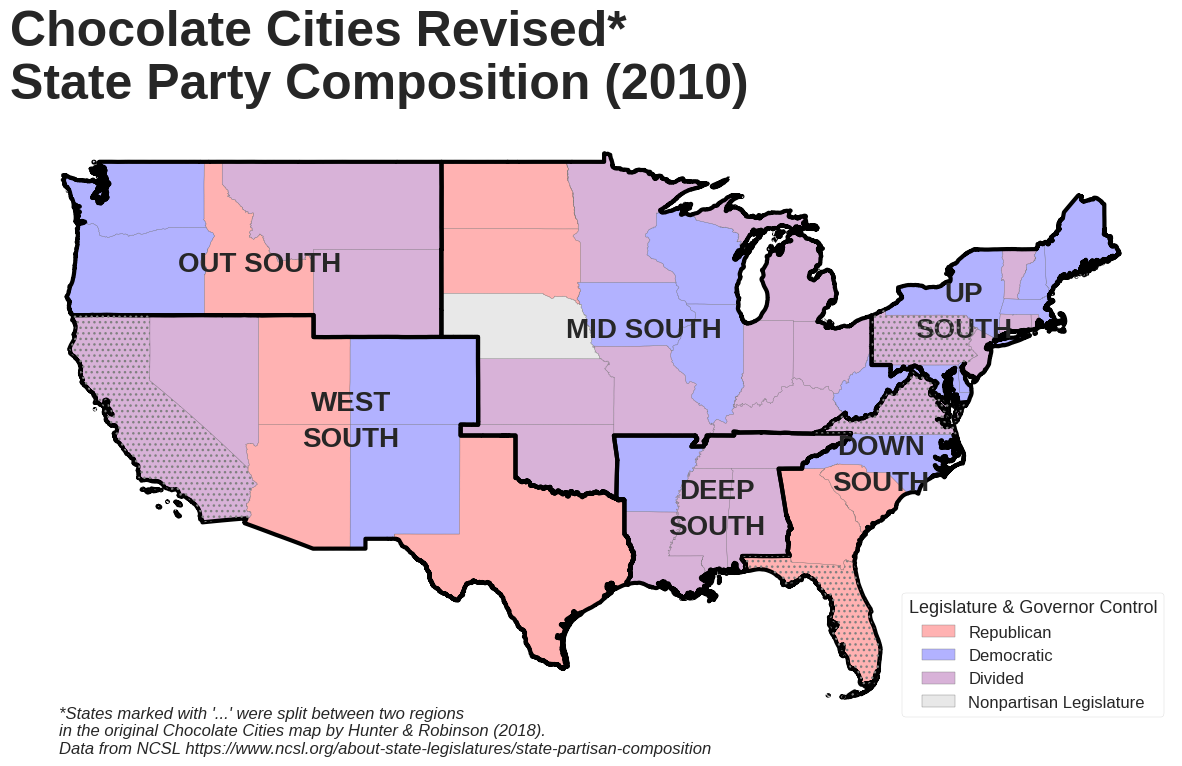

In [156]:
# Create regional geometries from the AllSouth column
regions = US.dissolve(by='AllSouth')

# Start plot
fig, ax = plt.subplots(1, figsize=(15, 50))

# Handle missing values
US['Party_filled'] = US['Party'].fillna('Other')

party_colors = {
    'Rep': (1, 0, 0, 0.3),       # soft red
    'Dem': (0, 0, 1, 0.3),       # soft blue
    'Divided': (0.5, 0, 0.5, 0.3),  # soft purple
    'Other': (0.7, 0.7, 0.7, 0.3)   # soft gray
}

# Now plot
US.plot(ax=ax,
        color=US['Party_filled'].map(party_colors),
        edgecolor='grey',
        linewidth=0.20)

# Now layer region outlines
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Title
ax.set_title("Chocolate Cities Revised*\nState Party Composition (2010) ",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nData from NCSL https://www.ncsl.org/about-state-legislatures/state-partisan-composition",
        fontsize=12, ha='left', fontstyle='italic')

# Region label positions
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Custom legend using mpatches
legend_elements = [
    mpatches.Patch(facecolor=(1, 0, 0, 0.3), edgecolor='grey', label='Republican'),
    mpatches.Patch(facecolor=(0, 0, 1, 0.3), edgecolor='grey', label='Democratic'),
    mpatches.Patch(facecolor=(0.5, 0, 0.5, 0.3), edgecolor='grey', label='Divided'),
    mpatches.Patch(facecolor=(0.7, 0.7, 0.7, 0.3), edgecolor='grey', label='Nonpartisan Legislature')
]

# Add legend to the plot
ax.legend(handles=legend_elements, title='Legislature & Governor Control',
          loc='lower right', fontsize=12, title_fontsize=13, frameon=True, facecolor='white')

# Show final map
plt.show()

In [157]:
# Create sunburst 1: Party → Region
fig1 = px.sunburst(
    down_party,
    path=['Party', 'AllSouth'],
    values='Total',  # or 'count' if that's the column name
    color='Party',
    color_discrete_map={
        'Dem': 'blue',
        'Rep': 'red',
        'Divided': 'purple'
    }
)

# Create sunburst 2: Region → Party, using Party for consistent color mapping
fig2 = px.sunburst(
    down_party,
    path=['AllSouth', 'Party'],
    values='Total',  # or 'count'
    color='Party',
    color_discrete_map={
        'Dem': 'blue',
        'Rep': 'red',
        'Divided': 'purple'
    }
)

# Set up side-by-side layout
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("By Party → Region", "By Region → Party")
)

# Add the two sunbursts to the subplot
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

# Final layout adjustments
fig.update_layout(
    title_text="Chocolate Cities State Party Composition",
    title_x=0.5,
    margin=dict(t=80, l=0, r=0, b=0)
)

fig.show()

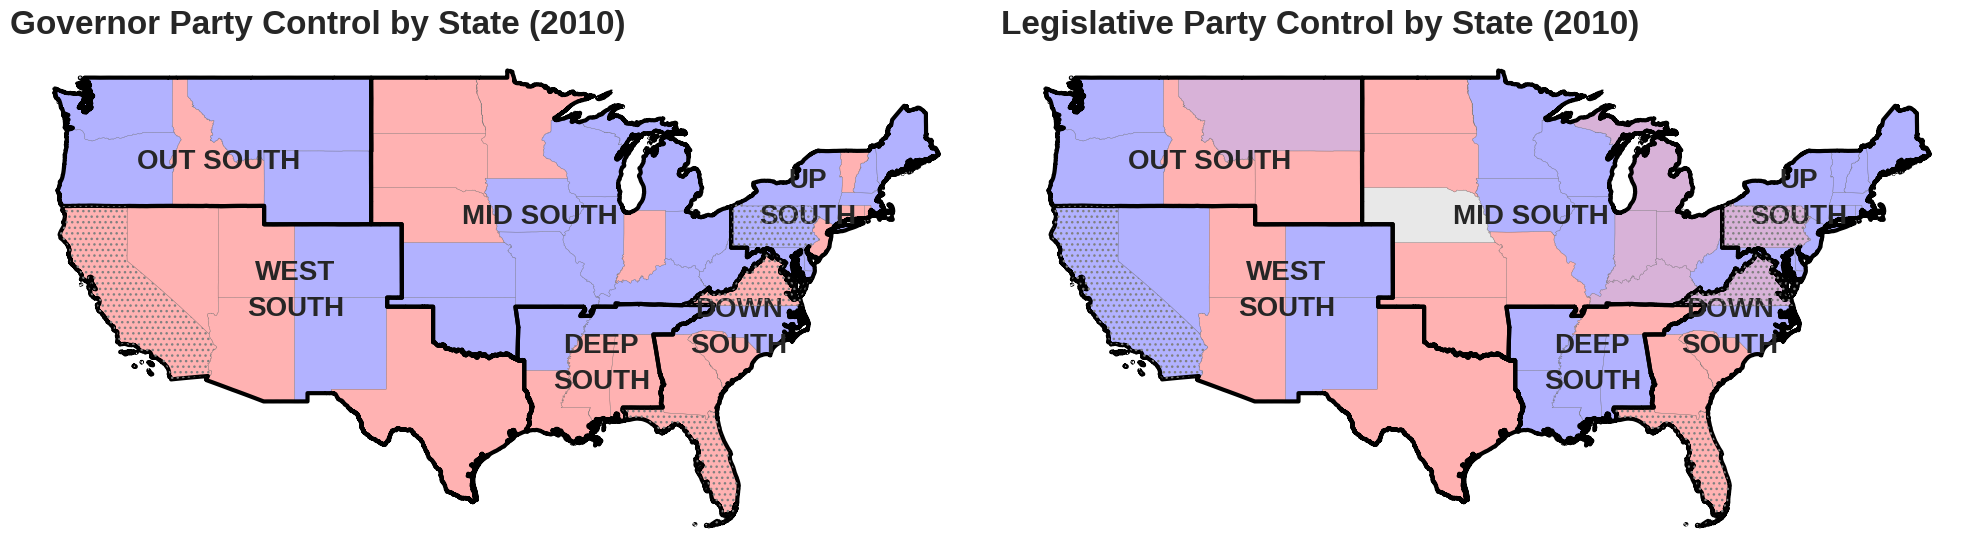

In [162]:
# Fill values
US['Gov_filled'] = US['Gov'].fillna('Other')
US['Leg_filled'] = US['Leg'].fillna('Other')

# Chocolate Cities setup
regions = US.dissolve(by='AllSouth')
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]

# Color mapping
party_colors = {
    'Rep': (1, 0, 0, 0.3),
    'Dem': (0, 0, 1, 0.3),
    'Divided': (0.5, 0, 0.5, 0.3),
    'Other': (0.7, 0.7, 0.7, 0.3)
}

# Region label positions and text
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}

# Create side-by-side layout
fig, axs = plt.subplots(1, 2, figsize=(20, 30))

# --- Governor Map ---
US.plot(ax=axs[0], color=US['Gov_filled'].map(party_colors), edgecolor='grey', linewidth=0.20)
regions.boundary.plot(ax=axs[0], edgecolor='black', linewidth=3)
split_states.plot(ax=axs[0], facecolor='none', edgecolor='grey', hatch='...', linewidth=0.01, zorder=5)
axs[0].set_title("Governor Party Control by State (2010)", loc='left', fontsize=24, fontweight='bold', pad=10)
axs[0].set_xticks([]); axs[0].set_yticks([]); axs[0].set_frame_on(False)

# --- Legislature Map ---
US.plot(ax=axs[1], color=US['Leg_filled'].map(party_colors), edgecolor='grey', linewidth=0.20)
regions.boundary.plot(ax=axs[1], edgecolor='black', linewidth=3)
split_states.plot(ax=axs[1], facecolor='none', edgecolor='grey', hatch='...', linewidth=0.01, zorder=5)
axs[1].set_title("Legislative Party Control by State (2010)", loc='left', fontsize=24, fontweight='bold', pad=10)
axs[1].set_xticks([]); axs[1].set_yticks([]); axs[1].set_frame_on(False)

# Add Chocolate Cities labels to BOTH maps
for ax in axs:
    for label, (x, y) in region_labels.items():
        ax.text(x, y, label_text[label],
                fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

plt.tight_layout()
plt.show()

In [238]:
# Count values using crosstab
party_counts = pd.crosstab(US['AllSouth'], US['Party'])
gov_counts   = pd.crosstab(US['AllSouth'], US['Gov'])
leg_counts   = pd.crosstab(US['AllSouth'], US['Leg'])

# Add prefixes to distinguish columns
party_counts.columns = [f"Party: {col}" for col in party_counts.columns]
gov_counts.columns   = [f"Gov: {col}" for col in gov_counts.columns]
leg_counts.columns   = [f"Leg: {col}" for col in leg_counts.columns]

# Combine all into one clean table
all_counts = pd.concat([party_counts, gov_counts, leg_counts], axis=1)

# Optional: Fill missing values with 0
all_counts = all_counts.fillna(0).astype(int)

# Show final table
all_counts.style.background_gradient(cmap='coolwarm', axis=0)

,Party: Dem,Party: Divided,Party: Rep,Gov: Dem,Gov: Rep,Leg: Dem,Leg: Divided,Leg: Rep
AllSouth,,,,,,,,
DEEP SOUTH,1,4,0,2,3,4,0,1
DOWN SOUTH,1,1,3,1,4,1,1,3
MID SOUTH,4,8,2,10,5,5,4,5
OUT SOUTH,2,2,1,4,1,2,1,2
UP SOUTH,6,5,0,7,4,10,1,0
WEST SOUTH,2,2,3,2,5,4,0,3


## Chocolate Cities Evaluating Census Data

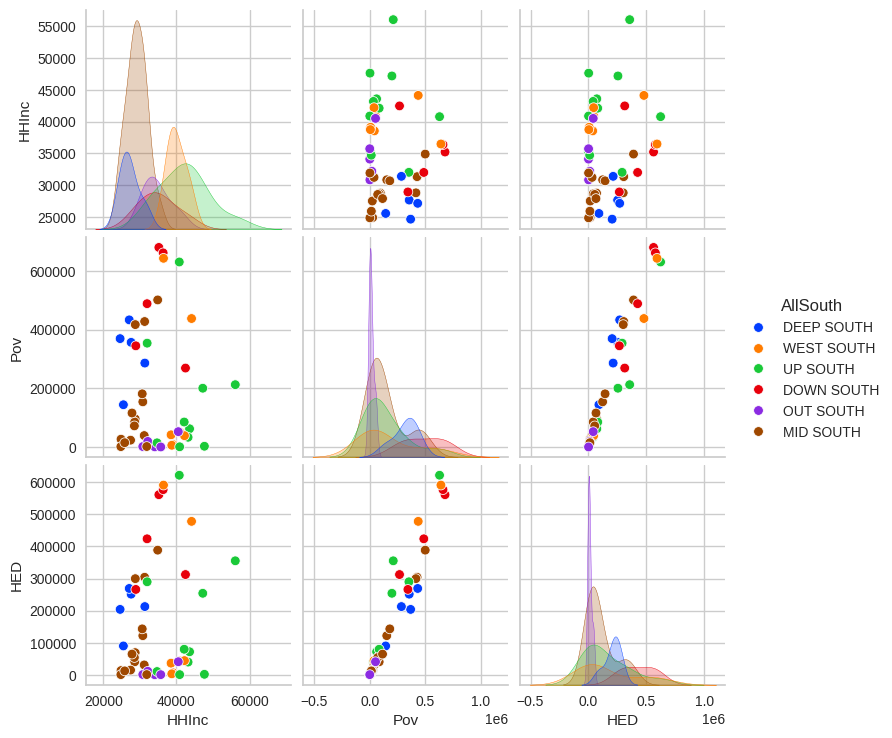

In [332]:
sns.pairplot(US, vars=["HHInc",'Pov','HED'], hue="AllSouth", palette="bright")

### Household Income

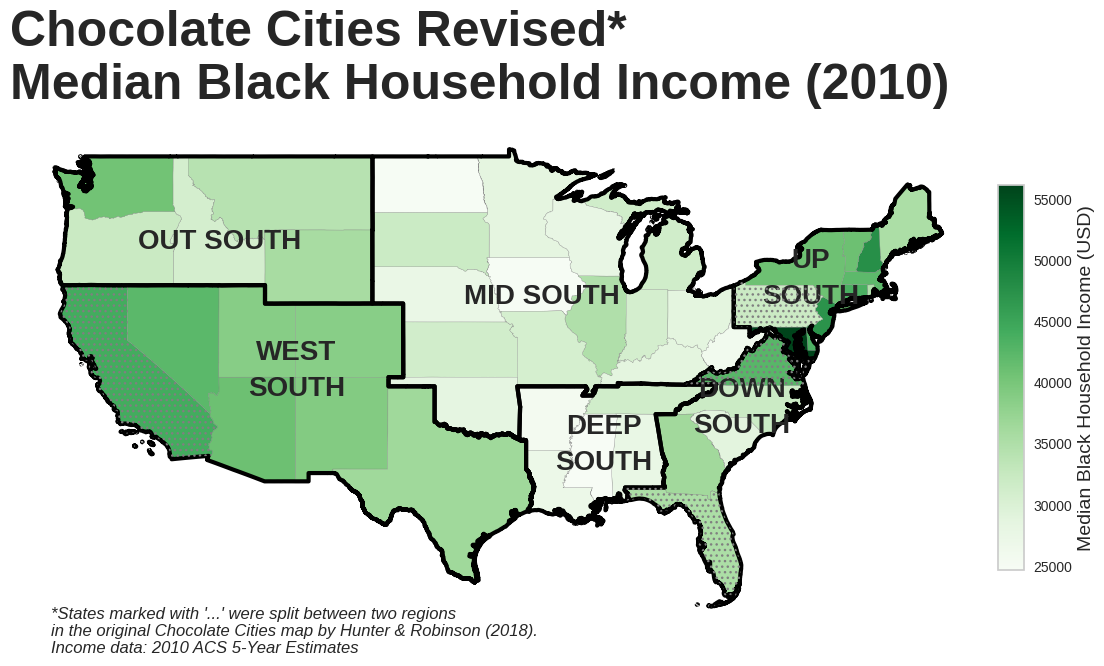

In [277]:
# Dissolve regions from 'AllSouth' column
regions = US.dissolve(by='AllSouth')

# Set up the figure and axis
fig, ax = plt.subplots(1, figsize=(15, 50))

# Plot using HHInc with Greens colormap
# Use column 'HHInc' — make sure it's numeric and has no NaNs
US['HHInc'] = pd.to_numeric(US['HHInc'], errors='coerce')
US.plot(column='HHInc',
        cmap='Greens',
        linewidth=0.2,
        edgecolor='grey',
        legend=False,  # We'll add a custom colorbar
        ax=ax)

# Layer region boundaries
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Title
ax.set_title("Chocolate Cities Revised*\nMedian Black Household Income (2010)",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nIncome data: 2010 ACS 5-Year Estimates",
        fontsize=12, ha='left', fontstyle='italic')

# Add region labels
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Add colorbar for HHInc
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(
    vmin=US['HHInc'].min(), vmax=US['HHInc'].max()))
sm._A = []  # Hack to make ScalarMappable work without an array
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.1, aspect=15, pad=0.01)
cbar.set_label('Median Black Household Income (USD)', fontsize=14)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [276]:
fig = px.treemap(US, path=[px.Constant("Chocolate Cities by Population and Median Household Income (2010)"), 'AllSouth', 'State'], values='Pop',
                  color='HHInc', hover_data=['State'],
                  color_continuous_scale='Greens',
                  color_continuous_midpoint=np.average(US['HHInc'], weights=US['Pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

### Poverty

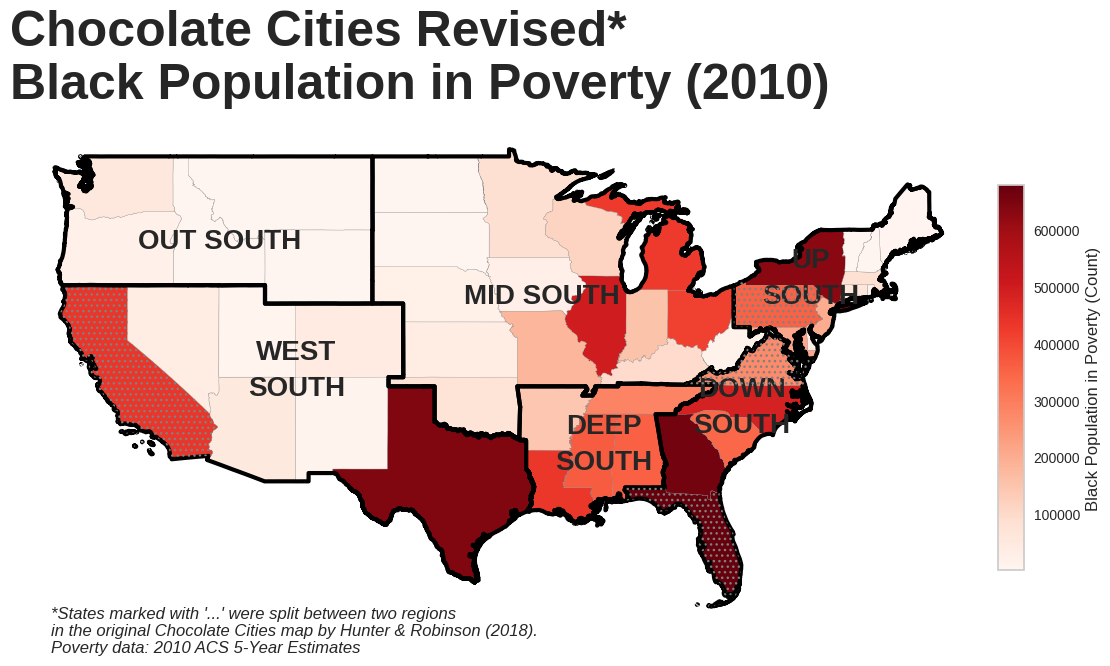

In [278]:
# Dissolve regions from 'AllSouth' column
regions = US.dissolve(by='AllSouth')

# Set up the figure and axis
fig, ax = plt.subplots(1, figsize=(15, 50))

# Make sure 'Pov' is numeric and has no NaNs
US['Pov'] = pd.to_numeric(US['Pov'], errors='coerce')

# Plot using 'Pov' with Reds colormap
US.plot(column='Pov',
        cmap='Reds',
        linewidth=0.2,
        edgecolor='grey',
        legend=False,
        ax=ax)

# Layer region boundaries
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Title
ax.set_title("Chocolate Cities Revised*\nBlack Population in Poverty (2010)",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nPoverty data: 2010 ACS 5-Year Estimates",
        fontsize=12, ha='left', fontstyle='italic')

# Region labels
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Add colorbar for 'Pov'
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(
    vmin=US['Pov'].min(), vmax=US['Pov'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.1, aspect=15, pad=0.01)
cbar.set_label('Black Population in Poverty (Count)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [279]:
fig = px.treemap(US, path=[px.Constant("Chocolate Cities by Population and Poverty (2010)"), 'AllSouth', 'State'], values='Pop',
                  color='Pov', hover_data=['State'],
                  color_continuous_scale='Reds',
                  color_continuous_midpoint=np.average(US['Pov'], weights=US['Pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

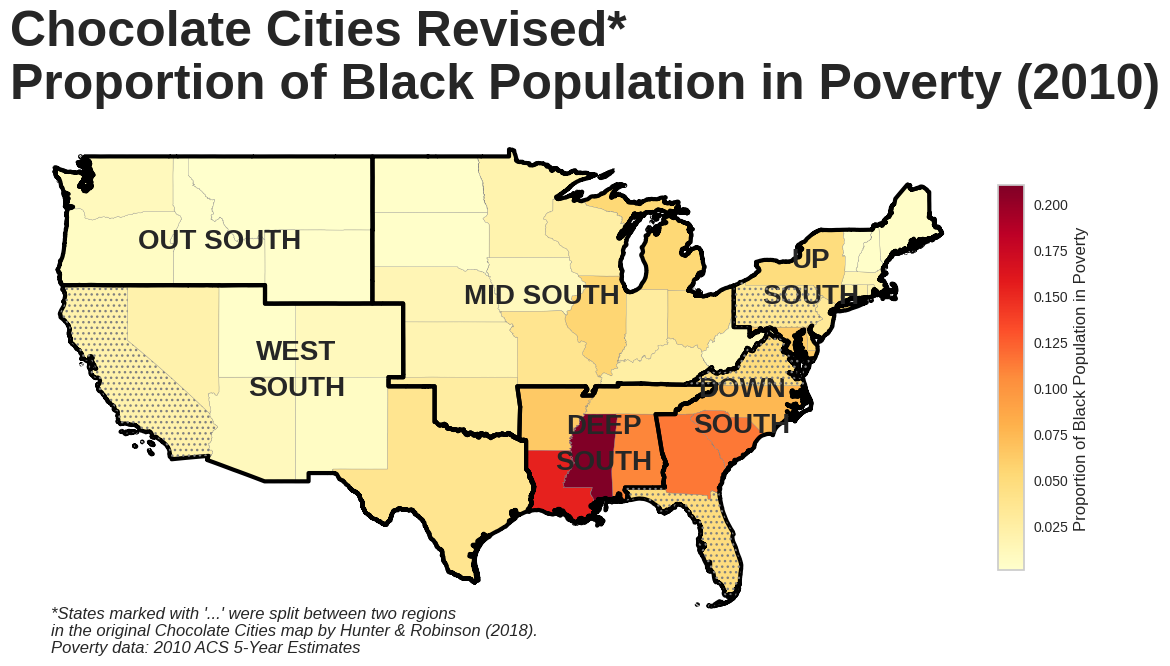

In [280]:
# Dissolve regions from 'AllSouth' column
regions = US.dissolve(by='AllSouth')

# Set up the figure and axis
fig, ax = plt.subplots(1, figsize=(15, 50))

# Ensure PovPop exists and is numeric
US['Pov'] = pd.to_numeric(US['Pov'], errors='coerce')
US['Pop'] = pd.to_numeric(US['Pop'], errors='coerce')
US['PovPop'] = (US['Pov'] / US['Pop']).round(3)  # or multiply by 100 for percent if you want

# Plot PovPop with YlOrRd colormap
US.plot(column='PovPop',
        cmap='YlOrRd',
        linewidth=0.2,
        edgecolor='grey',
        legend=False,
        ax=ax)

# Layer region boundaries
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Title
ax.set_title("Chocolate Cities Revised*\nProportion of Black Population in Poverty (2010)",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nPoverty data: 2010 ACS 5-Year Estimates",
        fontsize=12, ha='left', fontstyle='italic')

# Region labels
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Add colorbar for PovPop
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(
    vmin=US['PovPop'].min(), vmax=US['PovPop'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.1, aspect=15, pad=0.01)
cbar.set_label('Proportion of Black Population in Poverty', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [281]:
fig = px.treemap(US, path=[px.Constant("Chocolate Cities by Population and Proportion in Poverty (2010)"), 'AllSouth', 'State'], values='Pop',
                  color='PovPop', hover_data=['State'],
                  color_continuous_scale='YlOrRd',
                  color_continuous_midpoint=np.average(US['PovPop'], weights=US['Pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

### Higher Education

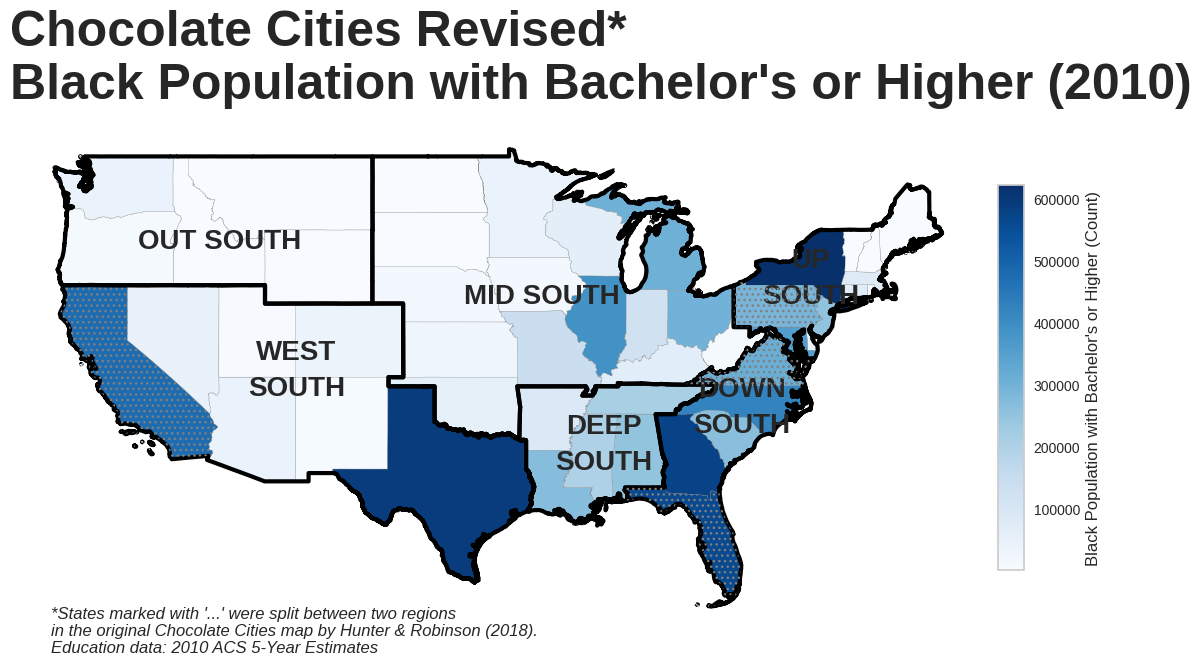

In [307]:
# Dissolve regions from 'AllSouth' column
regions = US.dissolve(by='AllSouth')

# Set up the figure and axis
fig, ax = plt.subplots(1, figsize=(15, 50))

# Make sure HED is numeric
US['HED'] = pd.to_numeric(US['HED'], errors='coerce')

# Plot using HED with Blues colormap
US.plot(column='HED',
        cmap='Blues',
        linewidth=0.2,
        edgecolor='grey',
        legend=False,
        ax=ax)

# Layer region boundaries
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Title
ax.set_title("Chocolate Cities Revised*\nBlack Population with Bachelor's or Higher (2010)",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nEducation data: 2010 ACS 5-Year Estimates",
        fontsize=12, ha='left', fontstyle='italic')

# Region labels
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Add colorbar for HED
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(
    vmin=US['HED'].min(), vmax=US['HED'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.1, aspect=15, pad=0.01)
cbar.set_label("Black Population with Bachelor's or Higher (Count)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()


In [302]:
fig = px.treemap(US, path=[px.Constant("Chocolate Cities by Population with HED Degree (2010)"), 'AllSouth', 'State'], values='Pop',
                  color='HED', hover_data=['State'],
                  color_continuous_scale='Blues',
                  color_continuous_midpoint=np.average(US['HED'], weights=US['Pop']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

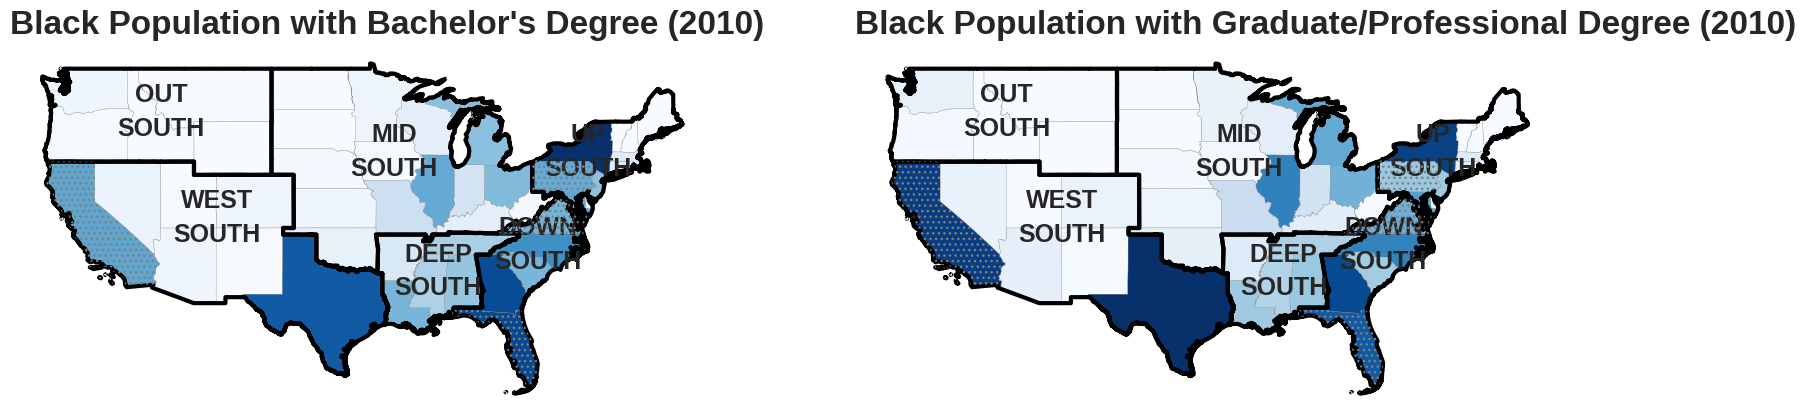

In [299]:
# Ensure numeric
US['Bach'] = pd.to_numeric(US['Bach'], errors='coerce')
US['Grad'] = pd.to_numeric(US['Grad'], errors='coerce')

# Setup
regions = US.dissolve(by='AllSouth')
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
region_labels = {
    "OUT SOUTH": (-114, 44), "WEST SOUTH": (-109, 36), "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41), "DOWN SOUTH": (-80, 34), "DEEP SOUTH": (-89, 32),
}
label_text = {k: k.replace(" ", "\n") if " " in k else k for k in region_labels}

# Create side-by-side layout
fig, axs = plt.subplots(1, 2, figsize=(20, 30))

def plot_map(ax, column, cmap, title):
    US.plot(column=column, cmap=cmap, linewidth=0.2, edgecolor='grey', legend=False, ax=ax)
    regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)
    split_states.plot(ax=ax, facecolor='none', edgecolor='grey', hatch='...', linewidth=0.01, zorder=5)
    ax.set_title(title, loc='left', fontsize=24, fontweight='bold', pad=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
    for label, (x, y) in region_labels.items():
        ax.text(x, y, label_text[label], fontsize=18, fontweight='bold', ha='center', linespacing=1.5)

plot_map(axs[0], 'Bach', 'Blues', "Black Population with Bachelor's Degree (2010)")
plot_map(axs[1], 'Grad', 'Blues', "Black Population with Graduate/Professional Degree (2010)")

plt.show()

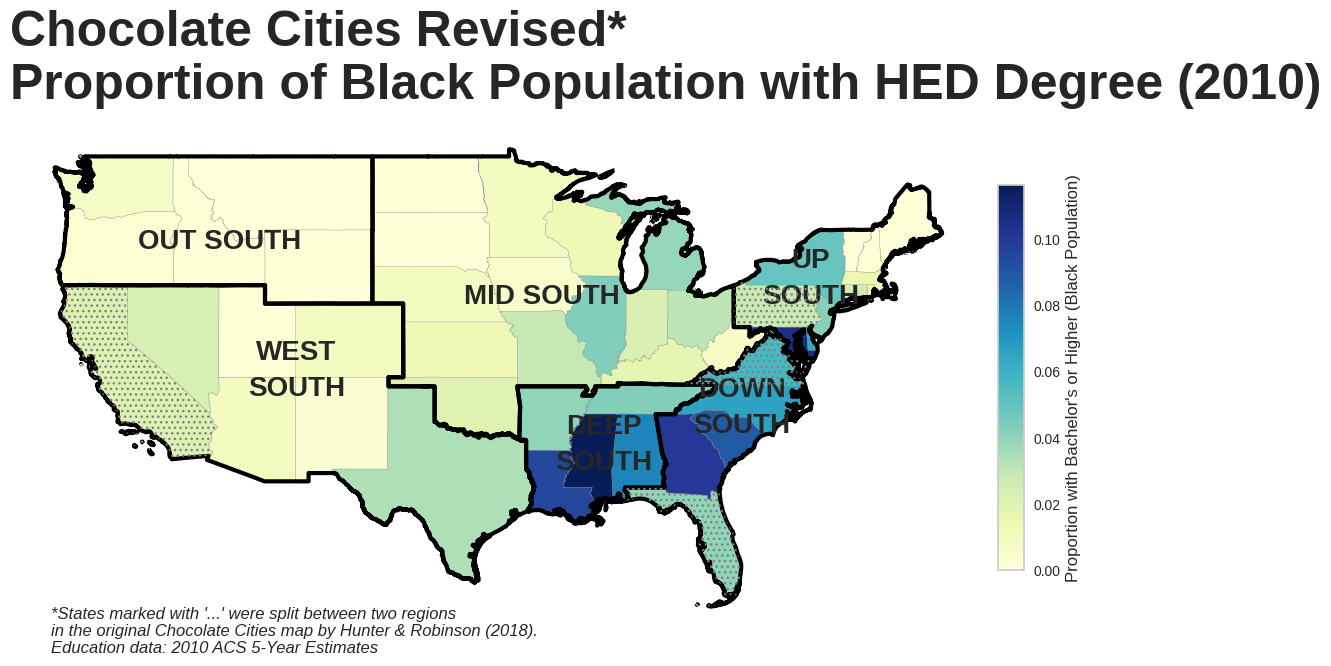

In [308]:
# Dissolve regions from 'AllSouth' column
regions = US.dissolve(by='AllSouth')

# Set up the figure and axis
fig, ax = plt.subplots(1, figsize=(15, 50))

# Plot using HEDPop with YlGnBu colormap
US.plot(column='HEDPop',
        cmap='YlGnBu',
        linewidth=0.2,
        edgecolor='grey',
        legend=False,
        ax=ax)

# Layer region boundaries
regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)

# Title
ax.set_title("Chocolate Cities Revised*\nProportion of Black Population with HED Degree (2010)",
             loc='left', fontsize=36, fontweight='bold', pad=20)

# Annotation
ax.text(-125, 22,
        "*States marked with '...' were split between two regions\nin the original Chocolate Cities map by Hunter & Robinson (2018).\nEducation data: 2010 ACS 5-Year Estimates",
        fontsize=12, ha='left', fontstyle='italic')

# Region labels
region_labels = {
    "OUT SOUTH": (-114, 44),
    "WEST SOUTH": (-109, 36),
    "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41),
    "DOWN SOUTH": (-80, 34),
    "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}
for label, (x, y) in region_labels.items():
    ax.text(x, y, label_text[label],
            fontsize=20, fontweight='bold', ha='center', linespacing=1.5)

# Hatched overlay on split states
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]
split_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='grey',
    hatch='...',
    linewidth=0.01,
    zorder=5
)

# Add colorbar for HEDPop
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(
    vmin=US['HEDPop'].min(), vmax=US['HEDPop'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.1, aspect=15, pad=0.01)
cbar.set_label("Proportion with Bachelor's or Higher (Black Population)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Axes cleanup
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()

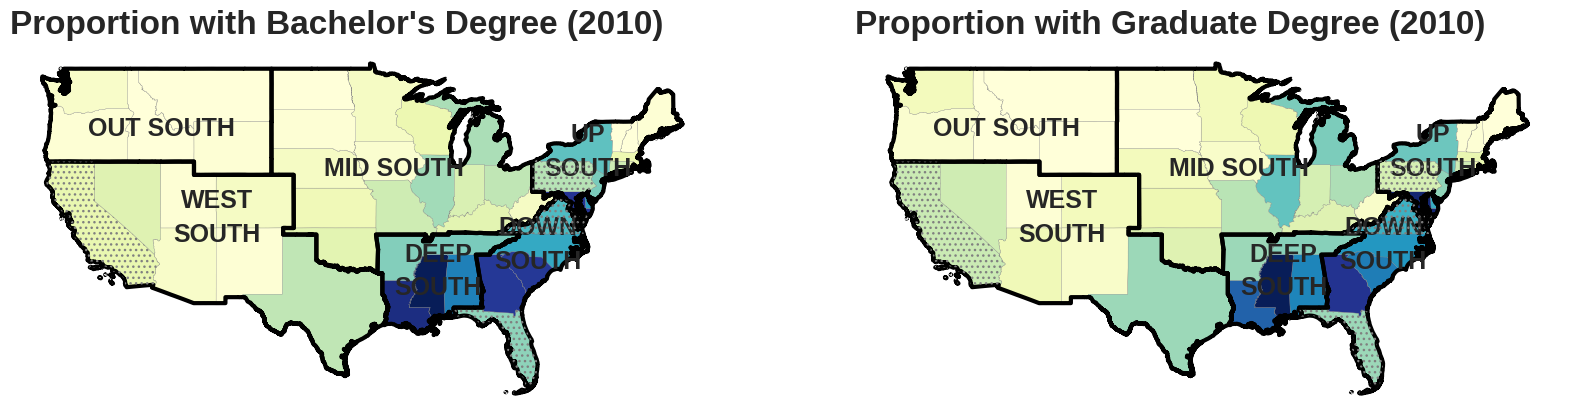

In [300]:
# Ensure numeric
US['Pop'] = pd.to_numeric(US['Pop'], errors='coerce')
US['Bach'] = pd.to_numeric(US['Bach'], errors='coerce')
US['Grad'] = pd.to_numeric(US['Grad'], errors='coerce')

# Compute proportions
US['BachPop'] = (US['Bach'] / US['Pop']).round(3)
US['GradPop'] = (US['Grad'] / US['Pop']).round(3)

# Setup for region boundaries and hatching
regions = US.dissolve(by='AllSouth')
split_states = US[US["State"].isin(["California", "Virginia", "Florida", "Pennsylvania"])]

# Region label positions and text
region_labels = {
    "OUT SOUTH": (-114, 44), "WEST SOUTH": (-109, 36), "MID SOUTH": (-93, 41),
    "UP SOUTH": (-75.5, 41), "DOWN SOUTH": (-80, 34), "DEEP SOUTH": (-89, 32),
}
label_text = {
    "OUT SOUTH": "OUT SOUTH",
    "WEST SOUTH": "WEST\nSOUTH",
    "MID SOUTH": "MID SOUTH",
    "UP SOUTH": "UP\nSOUTH",
    "DOWN SOUTH": "DOWN\nSOUTH",
    "DEEP SOUTH": "DEEP\nSOUTH"
}

# Shared plotting function
def plot_map(ax, column, cmap, title):
    US.plot(column=column, cmap=cmap, linewidth=0.2, edgecolor='grey', legend=False, ax=ax)
    regions.boundary.plot(ax=ax, edgecolor='black', linewidth=3)
    split_states.plot(ax=ax, facecolor='none', edgecolor='grey', hatch='...', linewidth=0.01, zorder=5)
    ax.set_title(title, loc='left', fontsize=24, fontweight='bold', pad=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_frame_on(False)
    for label, (x, y) in region_labels.items():
        ax.text(x, y, label_text[label], fontsize=18, fontweight='bold', ha='center', linespacing=1.5)

# Create side-by-side plot
fig, axs = plt.subplots(1, 2, figsize=(20, 30))

plot_map(axs[0], 'BachPop', 'YlGnBu', "Proportion with Bachelor's Degree (2010)")
plot_map(axs[1], 'GradPop', 'YlGnBu', "Proportion with Graduate Degree (2010)")

plt.show()